In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

train.loc[train['Team1'] == train['MatchWinner'],'MatchWinner'] = 1
train.loc[train['Team2'] == train['MatchWinner'],'MatchWinner'] = 2

traintest = pd.concat([train,test], axis=0)

traintest.head()

,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner
0,5,4,37,4,Home,Away,Second,First,Dec,2.0
1,1,14,84,7,Neutral,Neutral,First,Second,Sep,1.0
2,9,15,47,9,Home,Away,First,Second,Feb,1.0
3,7,2,102,6,Home,Away,First,Second,Aug,2.0
4,6,8,46,5,Home,Away,First,Second,Aug,1.0


In [3]:
def logloss(actual,pred):
    return log_loss(actual,pred,labels=[1,2])

In [4]:
venue = {'Home': 1,
         'Neutral': 0,
         'Away': -1}

month = {'Jan': 1,
         'Feb': 2,
         'Mar': 3,
         'Apr': 4,
         'May': 5,
         'Jun': 6,
         'Jul': 7,
         'Aug': 8,
         'Sep': 9,
         'Oct': 10,
         'Nov': 11,
         'Dec': 12}

innings = {'First': 1,
           'Second': 2}

def map_venue(x):
    return venue[x]

def map_month(x):
    return month[x]

def map_innings(x):
    return innings[x]

def comb_venue(x):
    if (x==-1):
        return 2
    else:
        return x

traintest.Team1_Venue = traintest.Team1_Venue.apply(map_venue)
traintest.Team2_Venue = traintest.Team2_Venue.apply(map_venue)
traintest['Venue'] = traintest.Team1_Venue.apply(comb_venue)
#traintest = traintest.drop(['Team1_Venue','Team2_Venue'], axis= 1)

traintest['Innings'] = traintest.Team1_Innings.apply(map_innings)
traintest.Team1_Innings = traintest.Team1_Innings.apply(map_innings)
traintest.Team2_Innings = traintest.Team2_Innings.apply(map_innings)
#traintest = traintest.drop(['Team1_Innings','Team2_Innings'], axis= 1)

traintest.MonthOfMatch = traintest.MonthOfMatch.apply(map_month)

train = traintest[:train.shape[0]]

traintest.head()

,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner,Venue,Innings
0,5,4,37,4,1,-1,2,1,12,2.0,1,2
1,1,14,84,7,0,0,1,2,9,1.0,0,1
2,9,15,47,9,1,-1,1,2,2,1.0,1,1
3,7,2,102,6,1,-1,1,2,8,2.0,1,1
4,6,8,46,5,1,-1,1,2,8,1.0,1,1


## Mean Encoding

In [5]:
win_percent = {}

for i in range(16):
    ctr = 0
    tot = 0
    ctr += train[(train['Team1'] == i) & (train['MatchWinner'] == 1)].shape[0]
    ctr += train[(train['Team2'] == i) & (train['MatchWinner'] == 2)].shape[0]
    tot += train[train['Team1'] == i].shape[0]
    tot += train[train['Team2'] == i].shape[0]
    
    win_percent[i] = ctr/tot
    
win_percent

{0: 0.48214285714285715,
 1: 0.8,
 2: 0.3111111111111111,
 3: 0.16326530612244897,
 4: 0.48008849557522126,
 5: 0.5016611295681063,
 6: 0.4342105263157895,
 7: 0.24489795918367346,
 8: 0.3333333333333333,
 9: 0.43487394957983194,
 10: 0.5547703180212014,
 11: 0.34615384615384615,
 12: 0.5963541666666666,
 13: 0.4584139264990329,
 14: 0.49209486166007904,
 15: 0.2670807453416149}

In [6]:
def map_win_percent(x):
    return win_percent[x]

traintest['Team1_win'] = traintest['Team1'].apply(map_win_percent)
traintest['Team2_win'] = traintest['Team2'].apply(map_win_percent)

traintest.head()

,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner,Venue,Innings,Team1_win,Team2_win
0,5,4,37,4,1,-1,2,1,12,2.0,1,2,0.501661,0.480088
1,1,14,84,7,0,0,1,2,9,1.0,0,1,0.800000,0.492095
2,9,15,47,9,1,-1,1,2,2,1.0,1,1,0.434874,0.267081
3,7,2,102,6,1,-1,1,2,8,2.0,1,1,0.244898,0.311111
4,6,8,46,5,1,-1,1,2,8,1.0,1,1,0.434211,0.333333


In [7]:
batting_win_percent = {}
bowling_win_percent = {}

for i in range(16):
    bat_ctr = 0
    bat_tot = 0
    bowl_ctr = 0
    bowl_tot = 0
    
    bat_tot += train[(train['Team1']==i) & (train['Innings']==1)].shape[0]
    bat_ctr += train[(train['Team1']==i) & (train['Innings']==1) & (train['MatchWinner']==1)].shape[0]
    bat_tot += train[(train['Team2']==i) & (train['Innings']==2)].shape[0]
    bat_ctr += train[(train['Team2']==i) & (train['Innings']==2) & (train['MatchWinner']==2)].shape[0]
    
    batting_win_percent[i] = bat_ctr/bat_tot
    
    bowl_tot = train[(train['Team1']==i) & (train['Innings']==2)].shape[0]
    bowl_ctr = train[(train['Team1']==i) & (train['Innings']==2) & (train['MatchWinner']==2)].shape[0]
    bowl_tot = train[(train['Team2']==i) & (train['Innings']==1)].shape[0]
    bowl_ctr = train[(train['Team2']==i) & (train['Innings']==1) & (train['MatchWinner']==1)].shape[0]
    
    bowling_win_percent[i] = bowl_ctr/bowl_tot
    
    
batting_win_percent

{0: 0.38461538461538464,
 1: 0.8105590062111802,
 2: 0.2894736842105263,
 3: 0.08333333333333333,
 4: 0.45145631067961167,
 5: 0.4618181818181818,
 6: 0.4594594594594595,
 7: 0.19642857142857142,
 8: 0.21052631578947367,
 9: 0.4031620553359684,
 10: 0.5612903225806452,
 11: 0.2857142857142857,
 12: 0.595,
 13: 0.4653846153846154,
 14: 0.47368421052631576,
 15: 0.26666666666666666}

In [8]:
def map_batting_win(x):
    return batting_win_percent[x]
    
def map_bowling_win(x):
    return batting_win_percent[x]
    
traintest['Team1_innings_win'] = traintest['Innings']
traintest['Team2_innings_win'] = traintest['Innings']

traintest.loc[traintest['Innings'] == 1,'Team1_innings_win'] = traintest[traintest['Innings'] == 1].Team1.apply(map_batting_win)
traintest.loc[traintest['Innings'] == 2,'Team2_innings_win'] = traintest[traintest['Innings'] == 2].Team2.apply(map_batting_win)
traintest.loc[traintest['Innings'] == 1,'Team2_innings_win'] = traintest[traintest['Innings'] == 1].Team2.apply(map_bowling_win)
traintest.loc[traintest['Innings'] == 2,'Team1_innings_win'] = traintest[traintest['Innings'] == 2].Team1.apply(map_bowling_win)

#traintest = traintest.drop(['Innings'], axis=1)

traintest.head()

,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner,Venue,Innings,Team1_win,Team2_win,Team1_innings_win,Team2_innings_win
0,5,4,37,4,1,-1,2,1,12,2.0,1,2,0.501661,0.480088,0.461818,0.451456
1,1,14,84,7,0,0,1,2,9,1.0,0,1,0.800000,0.492095,0.810559,0.473684
2,9,15,47,9,1,-1,1,2,2,1.0,1,1,0.434874,0.267081,0.403162,0.266667
3,7,2,102,6,1,-1,1,2,8,2.0,1,1,0.244898,0.311111,0.196429,0.289474
4,6,8,46,5,1,-1,1,2,8,1.0,1,1,0.434211,0.333333,0.459459,0.210526


In [9]:
home_win_percent = {}
away_win_percent = {}
neutral_win_percent = {}

for i in range(16):
    home_ctr = 0
    home_tot = 0
    away_ctr = 0
    away_tot = 0
    neu_ctr = 0
    neu_tot = 0
    
    home_tot += train[(train['Team1']==i) & (train['Venue']==1)].shape[0]
    home_ctr += train[(train['Team1']==i) & (train['Venue']==1) & (train['MatchWinner']==1)].shape[0]
    home_tot += train[(train['Team2']==i) & (train['Venue']==2)].shape[0]
    home_ctr += train[(train['Team2']==i) & (train['Venue']==2) & (train['MatchWinner']==2)].shape[0]
    
    if(home_tot != 0):
        home_win_percent[i] = home_ctr/home_tot
    else:
        home_win_percent[i] = 0.0
    
    away_tot += train[(train['Team1']==i) & (train['Venue']==2)].shape[0]
    away_ctr += train[(train['Team1']==i) & (train['Venue']==2) & (train['MatchWinner']==1)].shape[0]
    away_tot += train[(train['Team2']==i) & (train['Venue']==1)].shape[0]
    away_ctr += train[(train['Team2']==i) & (train['Venue']==1) & (train['MatchWinner']==2)].shape[0]
    
    away_win_percent[i] = away_ctr/away_tot
    
    neu_tot += train[((train['Team1']==i) | (train['Team2']==i)) & (train['Venue']==0)].shape[0]
    neu_ctr += train[(train['Team1']==i) & (train['Venue']==0) & (train['MatchWinner']==1)].shape[0]
    neu_ctr += train[(train['Team2']==i) & (train['Venue']==0) & (train['MatchWinner']==2)].shape[0]
    
    neutral_win_percent[i] = neu_ctr/neu_tot
    
    
home_win_percent

{0: 0.0,
 1: 0.6748251748251748,
 2: 0.4326923076923077,
 3: 0.2,
 4: 0.49473684210526314,
 5: 0.5048543689320388,
 6: 0.5151515151515151,
 7: 0.4,
 8: 0.5,
 9: 0.5306122448979592,
 10: 0.6052631578947368,
 11: 0.45,
 12: 0.6402439024390244,
 13: 0.5821917808219178,
 14: 0.4625,
 15: 0.29133858267716534}

In [10]:
def map_home_win(x):
    return home_win_percent[x]
    
def map_away_win(x):
    return away_win_percent[x]

def map_neutral_win(x):
    return neutral_win_percent[x]
    
traintest['Team1_venue_win'] = traintest['Venue']
traintest['Team2_venue_win'] = traintest['Venue']

traintest.loc[traintest['Venue'] == 1,'Team1_venue_win'] = traintest[traintest['Venue'] == 1].Team1.apply(map_home_win)
traintest.loc[traintest['Venue'] == 2,'Team2_venue_win'] = traintest[traintest['Venue'] == 2].Team2.apply(map_home_win)
traintest.loc[traintest['Venue'] == 1,'Team2_venue_win'] = traintest[traintest['Venue'] == 1].Team2.apply(map_away_win)
traintest.loc[traintest['Venue'] == 2,'Team1_venue_win'] = traintest[traintest['Venue'] == 2].Team1.apply(map_away_win)

traintest.loc[traintest['Venue'] == 0,'Team1_venue_win'] = traintest[traintest['Venue'] == 0].Team1.apply(map_neutral_win)
traintest.loc[traintest['Venue'] == 0,'Team2_venue_win'] = traintest[traintest['Venue'] == 0].Team2.apply(map_neutral_win)


#traintest = traintest.drop(['Venue'], axis=1)

traintest.head()

,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner,Venue,Innings,Team1_win,Team2_win,Team1_innings_win,Team2_innings_win,Team1_venue_win,Team2_venue_win
0,5,4,37,4,1,-1,2,1,12,2.0,1,2,0.501661,0.480088,0.461818,0.451456,0.504854,0.416216
1,1,14,84,7,0,0,1,2,9,1.0,0,1,0.800000,0.492095,0.810559,0.473684,0.754902,0.546099
2,9,15,47,9,1,-1,1,2,2,1.0,1,1,0.434874,0.267081,0.403162,0.266667,0.530612,0.228571
3,7,2,102,6,1,-1,1,2,8,2.0,1,1,0.244898,0.311111,0.196429,0.289474,0.400000,0.209877
4,6,8,46,5,1,-1,1,2,8,1.0,1,1,0.434211,0.333333,0.459459,0.210526,0.515152,0.153846


In [11]:
useless_tree_feat = ['Team1_win','Team2_win','Venue','Innings','Team1_innings_win','Team2_innings_win',
                     'Team1_venue_win','Team2_venue_win']
useless_lin_feat = ['Team1','Team2','Team1_Venue','Team2_Venue','Team1_Innings','Team2_Innings','Venue','Innings']

## Tree Models

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

train = traintest[:train.shape[0]]
test = traintest[train.shape[0]:]

X = (train.drop(['MatchWinner']+useless_tree_feat, axis = 1))
y = (train.MatchWinner)

Xtest = (test.drop(['MatchWinner']+useless_tree_feat, axis = 1))

In [13]:
clf1 = xgb.XGBClassifier()

clf1.fit(X,y)
predictions1 = clf1.predict_proba(Xtest)

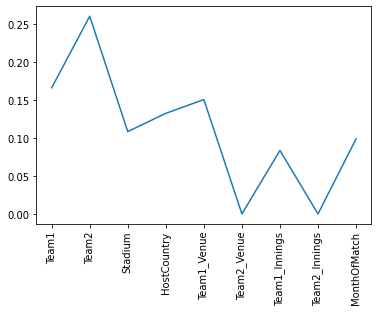

In [14]:
plt.plot(clf1.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

In [15]:
clf2 = RandomForestClassifier(n_estimators=500)

clf2.fit(X,y)
predictions2 = clf2.predict_proba(Xtest)

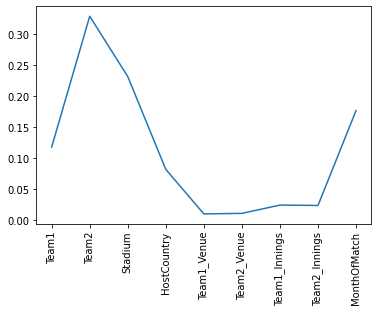

In [16]:
plt.plot(clf2.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

## Linear Models

In [17]:
X = (train.drop(['MatchWinner']+useless_lin_feat, axis = 1))
y = (train.MatchWinner)

Xtest = (test.drop(['MatchWinner']+useless_lin_feat, axis = 1))

In [18]:
clf3 = LogisticRegression(max_iter=500)

clf3.fit(X,y)
predictions3 = clf3.predict_proba(Xtest)

In [19]:
clf4 = MultinomialNB()

clf4.fit(X,y)
predictions4 = clf4.predict_proba(Xtest)

In [20]:
predictions = (predictions1 + predictions2 + predictions3 + predictions4)/4

In [21]:
submission = pd.read_excel('Sample_submission.xlsx')

submission = submission.apply(lambda x: x*0)

for i,x in enumerate(predictions):
    submission[test['Team1'][i]][i] = x[0]
    submission[test['Team2'][i]][i] = x[1]
    
submission.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.000000,0.594256,0.0,0.405744,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.930466,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.069534,0.000000
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.291818,0.708182,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.457726,0.542274,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,0.796731,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.203269


In [22]:
#submission.to_excel('submission.xlsx', index=False)